In [211]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# Parametros
L = 40 # Tamaño del dominio (en unidades adimensionales)
N = 10000 # Numero de puntos espaciales
dx = L / N  # Paso espacial
print(dx)
xi = np.linspace(-L / 2, L / 2, N)  # Grid espacial en unidades adimensionales
dt = 0.001  # Paso temporal (en unidades adimensionales)
t_max = 6.24 # Tiempo final (tiempo maximo tuneleo)
t_steps = int(t_max / dt)  # Numero de pasos temporales



# Parámetros del paquete de ondas, función de onda input
xi0 = 0 # Posición inicial partícula
kappa_0 = 20 # Momento Inicial
psi0 = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa_0 * xi)
psi0_star = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(-1j * kappa_0 * xi)

# Barrera de potencial
alpha_param = 60
v_0 = 0 # Altura del potencial (V_0/Ec)
b = 0.5 # Grosor de la barrera (en unidades adimensionales, realmente es xi_b)
v = v_0 / (1 + np.abs(xi / b)**alpha_param)  # Forma explicita del potencial
v = np.zeros(N)



# Intervalo de medición de posicion
x_min = -5
x_max = 5

0.004


In [212]:
def perform_position_measurement (psi, xi, x_min, x_max):
    
    # Identify the indices of the spatial grid that fall within the measurement range
    measurement_indices = (xi >= x_min) & (xi <= x_max)

    # Create a new wavefunction that is zero outside the measurement range
    psi_measured = np.zeros_like(psi)
    psi_measured[measurement_indices] = psi[measurement_indices]


    return psi_measured

In [213]:
def calculate_position_probability(psi, xi, x_min, x_max):
    
    # Identify the indices of the spatial grid that fall within the measurement range
    measurement_indices = (xi >= x_min) & (xi <= x_max)

    # Calculate the probability by integrating the probability density over the measurement range
    probability = trapezoid(np.abs(psi[measurement_indices])**2, xi[measurement_indices])

    return probability

In [214]:
alpha = 1j * dt / (kappa_0 * dx**2)  
beta = 1j * dt * kappa_0 / 2  

diagonal_a = (1 + alpha + beta * v) * np.ones(N)
off_diagonal = -(alpha / 2) * np.ones(N - 1)
A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

diagonal_b = (1 - alpha - beta * v) * np.ones(N)
B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")

diagonal_c = (1 + alpha) * np.ones(N)
off_diagonalx = -(alpha / 2) * np.ones(N - 1)
C = diags([off_diagonal, diagonal_c, off_diagonal], [-1, 0, 1], format="csr")

diagonal_d = (1 - alpha) * np.ones(N)
D = diags([-off_diagonalx, diagonal_d, -off_diagonalx], [-1, 0, 1], format="csr")



In [215]:
def kinetic_energy(psi, xi):
    
    dx = xi[1] - xi[0]  
    d2psi_dx2 = np.gradient(np.gradient(psi, dx), dx)

    kinetic_energy = np.abs((1/kappa_0) * trapezoid(np.conjugate(psi) * d2psi_dx2, xi))
    
    return kinetic_energy

In [216]:
def potential_energy(psi, xi):

    potential_energy = np.abs((kappa_0) * trapezoid(np.conjugate(psi) * v * psi, xi))
    
    return potential_energy

4000
[4]


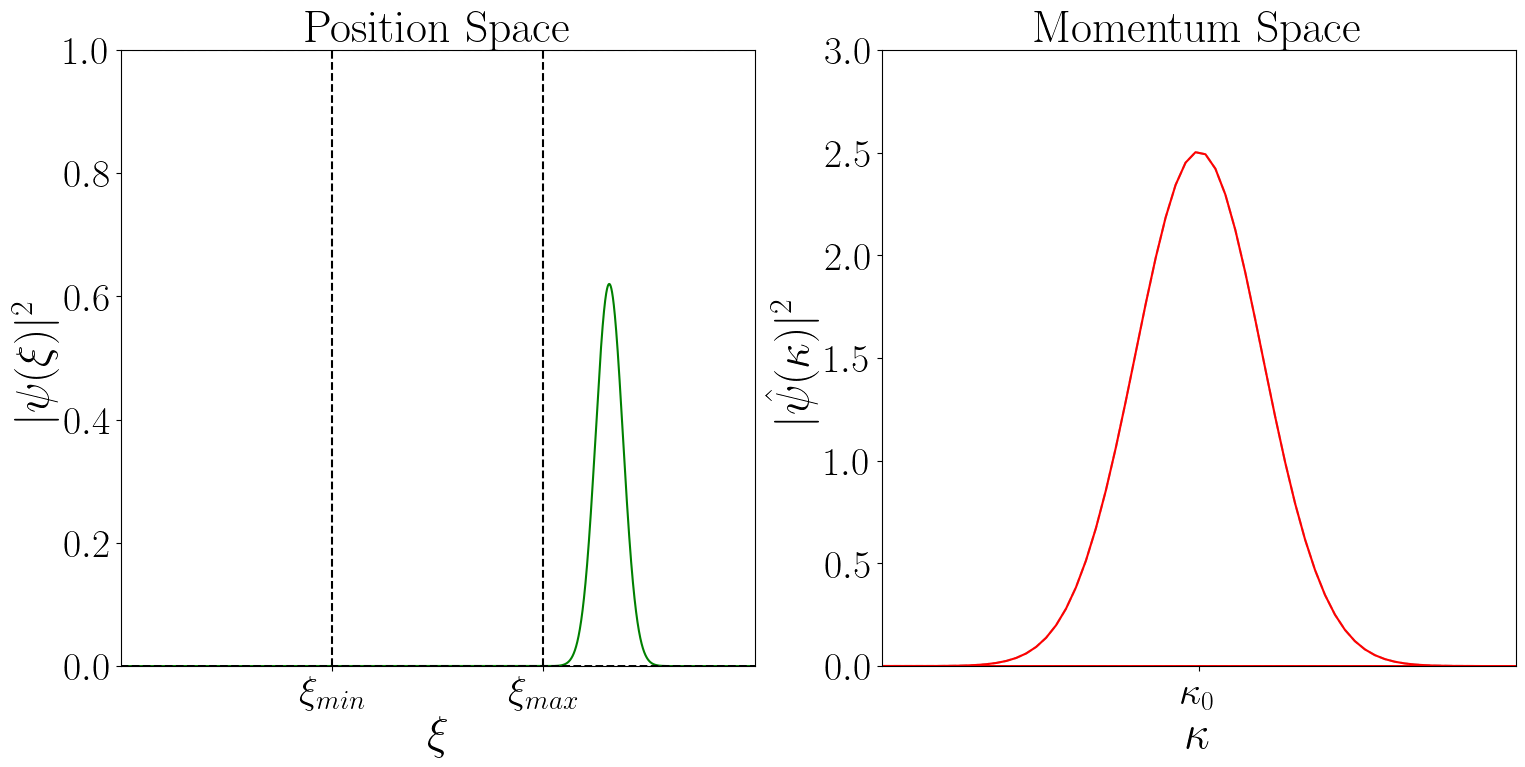

In [217]:
from matplotlib.animation import FuncAnimation 
from numpy.fft import fft, fftfreq, fftshift
from matplotlib import rcParams


# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']  # Default LaTeX font

# Transformada de Fourier para obtener psi en espacio de momentos
def psi_en_momentos(psi, k):
    psi_k = np.fft.fft(psi) * dx
    
    # # Normalizar (pendiente)
    # normalization_factor = np.sqrt(trapezoid(np.abs(psi_k)**2, k))
    # psi_k /= normalization_factor
    return psi_k

t_max = 4
t_start = 0
t_final = t_max
t_steps = int((t_max) / dt) 
print(t_steps)
 
# Inicialización de la función de onda
psi = psi0.copy()

psiref = psi0.copy()

psi_evolution = []
psi_evolution_ref = []
energy = []
energy1 = []



num_frames = 120
steps_per_frame = t_steps // num_frames

# Definir los intervalos de tiempo para hacer la medida
num_mediciones = 100000
num_mediciones = 1

if num_mediciones == 1:
    momentos_de_medicion = [t_max]  # One measurement at t_max
else:
    momentos_de_medicion = np.linspace(t_max / num_mediciones + t_start, t_final, num=num_mediciones)

# Índice para la siguiente medición

print(momentos_de_medicion)
indice_medicion = 0

probs = []

# Crear figuras para los dos gráficos: espacio de posiciones y momentos
fig, (ax_pos, ax_mom) = plt.subplots(1, 2, figsize=(18, 8))

# Linea para la densidad de probabilidad en posición
line_pos, = ax_pos.plot(xi, np.abs(psi)**2, color='green')
line_pos1, = ax_pos.plot(xi, np.abs(psiref)**2, color='green', linestyle = '--', alpha = 0)
ax_pos.set_title('Densidad de probabilidad en espacio de posiciones')
ax_pos.set_ylim(0, 1)  # Ajusta esto según tus datos
ax_pos.set_xlim (-15,15)

ax_pos.set_ylabel(r"$|\psi(\xi)|^2$", fontsize = 33)
ax_mom.set_ylabel(r"$|\hat{\psi}(\kappa)|^2$", fontsize = 33)
ax_pos.tick_params(axis='both', labelsize=28.5) 
ax_mom.tick_params(axis='both', labelsize=28.5) 


# ax_pos.legend(fontsize = 15)
# Linea para la densidad de probabilidad en momentos
k = np.fft.fftfreq(N, d=dx)*2*np.pi
psi_k = psi_en_momentos(psi,k)
psi_k1 = psi_en_momentos(psiref,k)

# Plot de la barrera
ax_pos.plot(xi, v*(2/3), color='k', linestyle='--',alpha = 1 )
ax_pos.axhline(y=1, color='k', linestyle='--', alpha=0.33)

# Distribucion de momento inicial
ax_mom.plot(k, np.abs(psi_k)**2, color= 'k', linestyle= '--', alpha = 0.33)

# Distribucion de momento final sin medidas
psi_k_star = psi_en_momentos(psi0_star,k)
ax_mom.plot(k, np.abs(psi_k_star)**2, color= 'k', linestyle= '--', alpha = 0.33)


line_mom, = ax_mom.plot(k, np.abs(psi_k)**2, color='red')
line_mom1, = ax_mom.plot(k, np.abs(psi_k1)**2, color = 'red', linestyle = '--', alpha = 0)

ax_mom.set_title('Densidad de probabilidad en espacio de momentos')
ax_mom.set_ylim(0, 3)  # Ajusta esto según tus datos
ax_mom.set_xlabel('k')
ax_mom.set_xlim(kappa_0 - 5, kappa_0 + 5)

ax_pos.axvline(x=x_max, color='k', linestyle='--', alpha=1)
ax_pos.axvline(x=x_min, color='k', linestyle='--', alpha=1)
# ax_pos.axvline(x=b, color='k', linestyle='--', alpha=0.33)
# ax_pos.axvline(x=-b, color='k', linestyle='--', alpha=0.33)
# ax_mom.axvline(x=-kappa_0, color='k', linestyle='--', alpha=0.33)
# ax_mom.axvline(x=kappa_0, color='k', linestyle='--', alpha=0.33)
ax_pos.set_xlabel(r"$\xi$", fontsize = 33)
ax_pos.set_xticks([-5, 5], [r"$\xi_{min}$",r"$\xi_{max}$"])
ax_mom.set_xlabel(r"$\kappa$", fontsize = 33)
ax_mom.set_xticks([kappa_0], [r"$\kappa_0$"])

# ax_pos.axvspan(-15, -5, color="grey",hatch="//", alpha=0.25)
# ax_pos.axvspan(5, 15, color="grey",hatch="//", alpha=0.25)

# ax_pos.text(0, 0.85, r"Zeno Subspace", 
#          fontsize=18, color="black", ha="center", bbox=dict(facecolor="white", alpha=0.8))


p = 1
q = 1
# ax_mom.legend(fontsize = 15)
kin_ene = kinetic_energy (psi, xi)
pot_ene0 = potential_energy (psi, xi)
Etot0 = kin_ene + pot_ene0

# # Actualizar los títulos
ax_pos.set_title(rf'Position Space', fontsize = 33)
ax_mom.set_title(f'Momentum Space', fontsize = 33)

# Función para actualizar el gráfico en cada paso de tiempo
# Función para actualizar el gráfico en cada paso de tiempo
def update(frame):
    global psi, indice_medicion, p, psiref, q, psi_evolution, psi_evolution_ref, psi_k, kin_ene, energy, energy1
    
    current_time = frame * steps_per_frame * dt  # Calculate current time

    psi_evolution.append((current_time, np.abs(psi)**2))
    psi_evolution_ref.append((current_time, np.abs(fftshift(psi_k))**2))
    energy.append((current_time,kin_ene/q))
    energy1.append((current_time,kin_ene))

    for _ in range(steps_per_frame):  
        # Evoluciona la función de onda varios pasos en cada cuadro
        psi = spsolve(A, B @ psi)
        psiref = spsolve(C, D @ psiref)

        kin_ene = kinetic_energy (psi, xi)
        pot_ene = potential_energy (psi, xi)

        mask_trans = (xi > b) 
        mask_ref = (xi < -b)

        psi_trans = psi[mask_trans]
        psi_ref = psi[mask_ref]

        kin_ene_trans = kinetic_energy (psi_trans, xi[mask_trans])
        kin_ene_ref = kinetic_energy (psi_ref, xi[mask_ref])

        pot_ene_trans = 0
        pot_ene_ref = 0

        etot_trans = kin_ene_trans + pot_ene_trans
        etot_ref = kin_ene_ref + pot_ene_ref

        current_time = current_time + dt

        # Verificar si estamos en un momento de medida
        if indice_medicion < len(momentos_de_medicion) and current_time >= momentos_de_medicion[indice_medicion]:
            # Calcular la probabilidad para k > 0
            p = p* calculate_position_probability(psi, xi, x_min, x_max)
            q = p
            print(p, current_time)
            p = 1
            psi = perform_position_measurement(psi, xi, x_min, x_max)
            indice_medicion += 1  # Pasar a la siguiente medida
            print(indice_medicion)

    # Actualizar la densidad de probabilidad en espacio de posiciones
    line_pos.set_ydata(np.abs(psi)**2)
    line_pos1.set_ydata(np.abs(psiref)**2)

    # Calcular psi en el espacio de momentos y actualizar gráfica
    psi_k = psi_en_momentos(psi, k)
    psi_k1 = psi_en_momentos(psiref, k)
    line_mom.set_ydata(np.abs(psi_k)**2)
    line_mom1.set_ydata(np.abs(psi_k1)**2)


    
    return line_pos, line_mom, line_pos1, line_mom1

# Crear la animación
ani = FuncAnimation(fig, update, frames=num_frames, blit=True)

# Guardar la animación
ani.save('position3.mp4', writer='ffmpeg', fps=30)


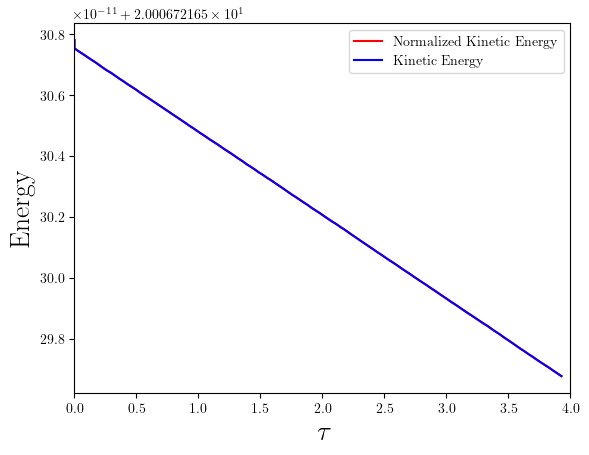

In [218]:
T1 = []
times = []

for i in range (len(energy)):
    T1.append(energy [i][1])
    times.append(energy[i][0])
T2 = []

for i in range (len(energy1)):
    T2.append(energy1 [i][1])

plt.plot(times, T1, label='Normalized Kinetic Energy', color='red')
plt.plot(times, T2, label='Kinetic Energy', color='blue')
plt.xlabel(r'$\tau$', fontsize = 20)
plt.ylabel('Energy', fontsize = 20)
plt.xlim(0,t_max)
plt.legend()

In [219]:
# Convertir la lista de tuplas en una matriz (n_x, n_t)
from numpy.fft import fftshift

density_matrix = np.array([density_t for _, density_t in psi_evolution]).T
density_matrix_ref = np.array([density_t for _, density_t in psi_evolution_ref]).T



# Extraer los tiempos y las posiciones
times = [t for t, _ in psi_evolution]  # Extraer los tiempos de la lista de tuplas
positions= xi


# Extraer los tiempos y las posiciones
times_ref = [t for t, _ in psi_evolution_ref]  # Extraer los tiempos de la lista de tuplas
k= np.fft.fftfreq(N, d=dx)*2*np.pi
k  = fftshift(k)

print(density_matrix_ref)


[[2.45755858e-34 3.31159954e-34 8.99513635e-34 ... 1.51655993e-32
  1.66344206e-32 2.69712900e-32]
 [3.62074035e-35 6.87183323e-34 4.18252714e-34 ... 1.34509840e-32
  9.04927421e-33 1.62327484e-32]
 [7.98952737e-35 1.14923431e-33 1.03545065e-34 ... 5.02828592e-32
  4.20408860e-32 4.54844320e-32]
 ...
 [1.36156841e-34 5.14638851e-34 3.72962456e-35 ... 9.19827723e-32
  1.01067434e-31 1.00575785e-31]
 [4.13493429e-34 7.39719835e-34 4.93879129e-35 ... 1.13130874e-31
  9.50193209e-32 1.09594814e-31]
 [9.20069358e-36 4.31249853e-34 2.04096104e-35 ... 6.34313168e-32
  6.06361473e-32 6.69816555e-32]]


<function matplotlib.pyplot.show(close=None, block=None)>

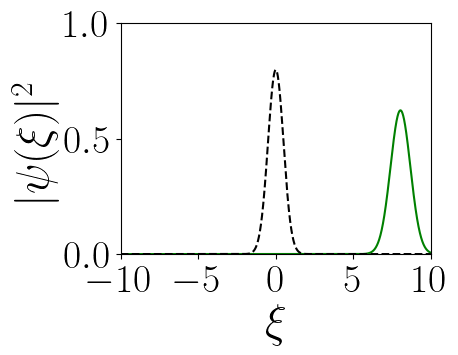

In [220]:
from matplotlib import rcParams


# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']  # Default LaTeX font
plt.figure(figsize=(4, 3))
plt.plot (xi, density_matrix.T [-1], color = 'Green', linewidth = 1.5)
plt.plot (xi, density_matrix.T [0], color = 'k', linestyle = '--', linewidth = 1.5)
plt.xlim (-7.5,10)
plt.ylim (0,1)
# plt.grid (True)
# plt.axvline(x = 5, color = 'k', linestyle = "--", linewidth = 1.5)
plt.xlabel(r"$\xi$", fontsize=33)
plt.ylabel(r"$|\psi(\xi)|^2$", fontsize=33)
plt.xticks([-10, -5, 0, 5, 10])
plt.tick_params(axis='both', labelsize=28.5) 
plt.show

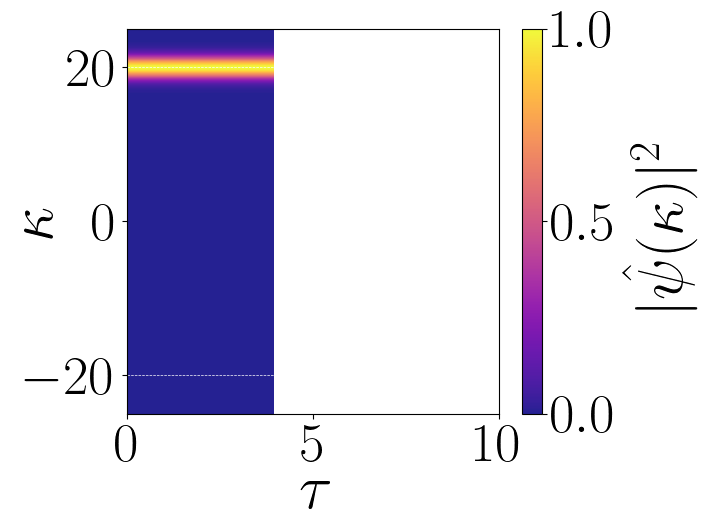

In [221]:
from matplotlib import rcParams


# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']  # Default LaTeX font

# Crear la figura
plt.figure(figsize=(6, 5))

# Mapa de calor para la barrera alta (colormap 'inferno' y rango consistente)

for i in range (len(times)):
    density_matrix_ref.T [i] = density_matrix_ref.T [i] / np.sqrt(trapezoid(np.abs(density_matrix_ref.T [i])**2, k))

im = plt.imshow(density_matrix_ref/np.max(density_matrix_ref), aspect='auto', cmap='plasma', origin='lower', 
                extent=[times_ref[0], times_ref[-1], k[0], k[-1]], alpha = 0.9, )

plt.ylim(-25, 25)


# # Líneas horizontales
# plt.axvline(x=2.5, color='white', linestyle='--', linewidth=0.5)
# plt.axvline(x=7.4, color='white', linestyle='--', linewidth=0.5)

# Añadir una barra de color para el mapa
cbar = plt.colorbar(im)
cbar.set_label(r"$|\hat{\psi}(\kappa)|^2$", fontsize=45)

cbar.ax.tick_params(labelsize=40) 

# Etiquetas de los ejes
plt.xlabel(r"$\tau$", fontsize=45, labelpad = -5)
plt.ylabel(r"$\kappa$", fontsize=45, labelpad = -30)
plt.tick_params(axis='both', labelsize=40) 
plt.axhline(y=20, color='white', linestyle='--', linewidth=0.5)
plt.axhline(y=-20, color='white', linestyle='--', linewidth=0.5)
plt.xticks([0, 5, 10])
plt.yticks([-20, 0, 20])


# Mostrar el gráfico
plt.show()

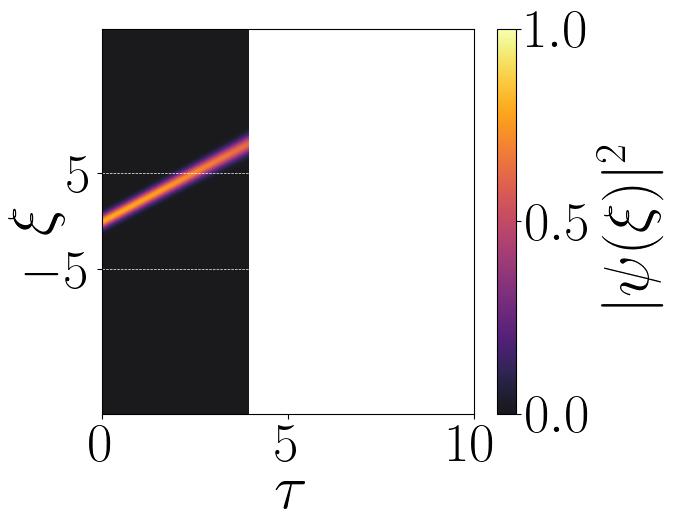

In [222]:
from matplotlib import rcParams


# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']  # Default LaTeX font

# Crear la figura
plt.figure(figsize=(6, 5))

# Mapa de calor para la barrera alta (colormap 'inferno' y rango consistente)


im = plt.imshow(density_matrix, aspect='auto', cmap='inferno', origin='lower', 
                extent=[times_ref[0], times_ref[-1], positions[0], positions[-1]], alpha = 0.9, vmin=0, vmax=1)



plt.axhline(y=x_max, color='white', linestyle='--', linewidth=0.5)
plt.axhline(y=x_min, color='white', linestyle='--', linewidth=0.5)



# # Líneas horizontales
# plt.axvline(x=2.5, color='white', linestyle='--', linewidth=0.5)
# plt.axvline(x=7.4, color='white', linestyle='--', linewidth=0.5)

# Añadir una barra de color para el mapa
cbar = plt.colorbar(im)
cbar.set_label(r"$|\psi(\xi)|^2$", fontsize=45)

# Etiquetas de los ejes
plt.xlabel(r"$\tau$", fontsize=45, labelpad = -5)
plt.ylabel(r"$\xi$", fontsize=45, labelpad = -30)
plt.tick_params(axis='both', labelsize=40) 
plt.xticks([0, 5, 10])
cbar.ax.tick_params(labelsize=40) 
plt.yticks([-5, 5])

# Mostrar el gráfico
plt.show()

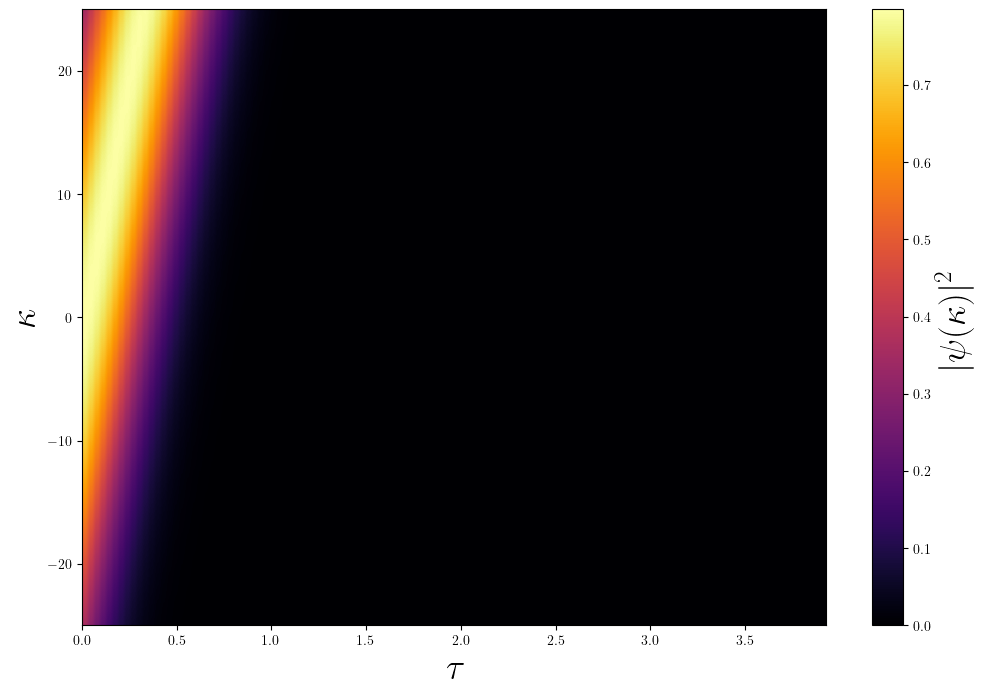

In [223]:
from matplotlib import rcParams


# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']  # Default LaTeX font

# Crear la figura
plt.figure(figsize=(12, 8))

# Mapa de calor para la barrera alta (colormap 'inferno' y rango consistente)


im = plt.imshow(density_matrix, aspect='auto', cmap='inferno', origin='lower', 
                extent=[times_ref[0], times_ref[-1], k[0], k[-1]])

plt.ylim(-25, 25)


# # Líneas horizontales
# plt.axhline(y=x_max, color='white', linestyle='--', linewidth=0.5)
# plt.axhline(y=x_min, color='white', linestyle='--', linewidth=0.5)

# Añadir una barra de color para el mapa
cbar = plt.colorbar(im)
cbar.set_label(r"$|\psi(\kappa)|^2$", fontsize=26)

# Etiquetas de los ejes
plt.xlabel(r"$\tau$", fontsize=26)
plt.ylabel(r"$\kappa$", fontsize=26)

# Mostrar el gráfico
plt.show()

In [224]:
print(density_matrix_ref.shape)  # Expect (num_positions, num_times)
print(k.shape)

(10000, 123)
(10000,)
